In [1]:
from person_tracking import tracking_frames
from data_utils import *
import argparse
import config
from trainer.fusiondiffroigan import Params,Fusion_Diff_ROI_3DCAE_GAN3D
from models import diff_ROI_C3D_AE_no_pool


Using TensorFlow backend.


In [56]:
#user input
detection_threshold=0.3
folder_path='../dataset/Thermal/frame/Fall/Fall35'

In [57]:
#parameters
WIDTH,HEIGHT=config.WIDTH,config.HEIGHT#original data specs
win_length=config.WIN_LENGTH
LOAD_DATA_SHAPE=config.LOAD_DATA_SHAPE
width, height,channels = LOAD_DATA_SHAPE[0],LOAD_DATA_SHAPE[1],LOAD_DATA_SHAPE[2]
break_win=config.SPLIT_GAP
stride=config.STRIDE


## Person tracking

In [58]:
input_folder=folder_path
#reading and sorting image paths
frames_path = glob.glob(input_folder+'/*.jpg') + glob.glob(input_folder+'/*.png')
frames_path,numbers = sort_frames(frames_path,'Thermal')




sorting Thermal frames...


In [59]:
#person tracking
boxes,track_numbers=tracking_frames(detection_threshold,frames_path,numbers,otsu_box=True)


 36%|███▋      | 293/804 [00:35<04:22,  1.95it/s]


 65%|██████▍   | 520/804 [01:39<01:51,  2.55it/s]


 89%|████████▊ | 713/804 [02:56<00:46,  1.96it/s]


100%|██████████| 804/804 [03:36<00:00,  3.71it/s]


In [60]:

# box_path='box.npy'
# numbers_path='numbers.npy'
# if os.path.exists(box_path) and  os.path.exists(numbers_path):
#     boxes=np.load(box_path)
#     track_numbers=np.load(numbers_path)
# else:
#     np.save(box_path,boxes)
#     np.save(numbers_path,track_numbers)

In [61]:
#preprocess boxes- remove -ve coordinates
boxes_proc=np.array([improve_box_cord(box,WIDTH,HEIGHT,offset=10) for box in boxes])
#creating dictionary with key:frame_num value:box with coordinates are scaled in range 0 to 1
boxes_fr=boxes_proc.copy()
boxes_fr=boxes_fr.astype('float64')
boxes_fr[:,0]=boxes_fr[:,0]/(1.0*HEIGHT)
boxes_fr[:,2]=boxes_fr[:,2]/(1.0*HEIGHT)
boxes_fr[:,1]=boxes_fr[:,1]/(1.0*WIDTH)
boxes_fr[:,3]=boxes_fr[:,3]/(1.0*WIDTH)
num_box_dict=dict(zip(track_numbers,boxes_fr))

##  Loading and Preprocessing thermal frames

In [62]:


print("Thermal preprocessing....")
video={}

#preprocessing all frames
video["ALL_FRAME"],_,_=preprocess_frames(frames_path,numbers,process_list=['Processed'],ht=height,wd=width,channels=channels,ROI_array=None)

Thermal preprocessing....
data.shape (804, 64, 64, 1)


In [63]:

tracked_frames_path=[]

for num in track_numbers:
    tracked_frames_path.append(frames_path[num-1])
#preprocessing tracked frames
#Data as numpy array and list of sorted frame numbers
data,frame_numbers,frames_path=preprocess_frames(tracked_frames_path,track_numbers,process_list=['Processed','ROI_frame'],ht=height,wd=width,channels=channels,ROI_array=boxes_proc)
#creating sub vidoes
data_list,frame_numbers_list=split_data_tracks(data,frame_numbers,gap=break_win,win_length=win_length)
#Split frames path
frames_path_list,_=split_data_tracks(frames_path,frame_numbers,gap=break_win,win_length=win_length)
video['ROI_FRAME']=data_list
video['NUMBER']=frame_numbers_list
video['PATH']=frames_path_list
print("\nCreating MASK data...........\n")
video['MASK']=create_ROI_mask(ROI_boxes=boxes_proc,ROI_numbers=track_numbers,img_shape=(config.HEIGHT,config.WIDTH,1),load_shape=config.LOAD_DATA_SHAPE,win_length=config.WIN_LENGTH,split_gap=config.SPLIT_GAP)
#optical flow computation

data.shape (530, 64, 64, 1)

Creating MASK data...........

ROI mask data shape (530, 64, 64, 1)


In [64]:
#image sample
sub_video_num=0
index=10
frame_num=video['NUMBER'][sub_video_num][index]

In [65]:
org_frame=video["ALL_FRAME"][frame_num-1]#1 numbering
roi_frame=video['ROI_FRAME'][sub_video_num][index]
mask=video['MASK'][sub_video_num][index]
box=num_box_dict[frame_num]

In [66]:
def gray_color_image(gray):
    gray_scaled=np.expand_dims(cv2.normalize(gray,None,0,1,cv2.NORM_MINMAX),axis=-1)
    gray_scaled=gray_scaled*255
    gray_scaled=gray_scaled.astype(np.uint8)
    org_color=np.concatenate([gray_scaled,gray_scaled,gray_scaled],axis=-1)
    return org_color
def roi_gray_color_image(roi_gray,box_fr):
    height,width=roi_gray.shape[0],roi_gray.shape[1]
    color_img=np.zeros((height,width,3),dtype='uint8')
    left, top, right, bottom=int(box[1]*width),int(box[0]*height),int(box[3]*width),int(box[2]*height)
    color_img[top:bottom,left:right,:]=gray_color_image(roi_gray[top:bottom,left:right,:])
    return color_img
    
    

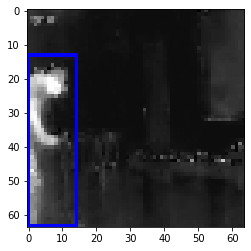

In [67]:
left, top, right, bottom=int(box[1]*width),int(box[0]*height),int(box[3]*width),int(box[2]*height)
plt.imshow(cv2.rectangle(gray_color_image(org_frame), (left, top), (right, bottom), (0, 0, 255),1))

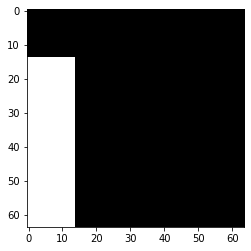

In [68]:
plt.imshow(mask[:,:,0],cmap='gray')

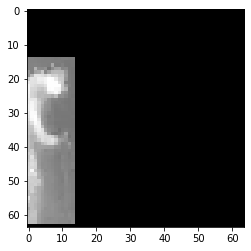

In [69]:
plt.imshow(roi_gray_color_image(roi_frame,box))

## Thermal Windows Reconstruction

In [70]:
from models import diff_ROI_C3D_AE_no_pool,ROI_C3D_AE_no_pool,Fusion_C3D_no_pool
from trainer.fusiondiffroigan import Params,Fusion_Diff_ROI_3DCAE_GAN3D
from trainer.util import agg_window,create_windowed_arr,get_output,gather_auc_avg_per_tol,join_mean_std,create_diff_mask

In [71]:
#parameters
dset = config.track_root_folder
d_type='ROI_Fusion'
thermal_channels=1
flow_channels=3
regularizer_list = ['BN']
epochs_trained=299
lambdas=[1.0,1.0,1.0]#T_S,T_T,F
thermal_3dcae_path='./Thermal_track/ROI_Fusion/ROI_C3DAE-no_pool-BN_diff_ROI_C3DAE_no_pool-BN_Fusion_C3D-no_pool-BN/lambda_TS1.0_TT1.0_F1.0/models/GAN_T_R_weights_epoch-299.h5'

In [72]:
param=Params(width=width, height=height,win_length=win_length,thermal_channels=thermal_channels,flow_channels=flow_channels \
             ,dset=dset,d_type=d_type,regularizer_list=regularizer_list,break_win=break_win)
param.thermal_lambda_S=lambdas[0]
param.thermal_lambda_T=lambdas[1]
param.flow_lambda=lambdas[2]

In [73]:
#trainer
GAN3D=Fusion_Diff_ROI_3DCAE_GAN3D(train_par=param,stride=stride)
#thermal reconstructor model 
#initialization
TR, TR_name, _ = diff_ROI_C3D_AE_no_pool(img_width=param.width, img_height=param.height, win_length=param.win_length, regularizer_list=param.regularizer_list,channels=param.thermal_channels,lambda_S=param.thermal_lambda_S,lambda_T=param.thermal_lambda_T,d_type='thermal')


In [74]:
#Loading weights
if os.path.isfile(thermal_3dcae_path):
    TR.load_weights(thermal_3dcae_path)
    GAN3D.T_R=TR
    print("Model weights loaded successfully........")
else:
    print("Saved model weights not found......")

Model weights loaded successfully........


#### Sliding window

In [75]:
vid_thermal_list=video['ROI_FRAME']
vid_thermal_mask_list=video['MASK']
frame_numbers_cat=np.concatenate(video['NUMBER'])

In [76]:
#creating windows of thermal frames for each subvideo separately
thermal_data_list = [vid.reshape(len(vid), param.width,param.height, param.thermal_channels) for vid in vid_thermal_list]
thermal_data_windowed_list = [create_windowed_arr(test_data, stride, param.win_length) for test_data in thermal_data_list]#create_windowe

In [77]:
# creating windows of mask data
thermal_mask_list = [vid.reshape(len(vid), param.width,param.height, param.thermal_channels) for vid in vid_thermal_mask_list]

thermal_mask_windowed_list = [create_windowed_arr(test_data, stride, param.win_length).astype('int8') for test_data in thermal_mask_list]
# creating windows of mask of difference frames
diff_mask_windowed_list=[create_diff_mask(mask_windows) for mask_windows in thermal_mask_windowed_list]

In [78]:
num_sub_videos=len(thermal_data_windowed_list)

### Model prediction, frame level anomaly scores and thermal reconstruction

In [79]:
def get_cross_window_frames(recons_seq,height,width,channels,win_length):
    '''
        Take mean of the reconstructed frames present in different windows corresponding to the actual frame timestamp
    '''
    seq_num=recons_seq.shape[0]+win_length-1
    sum_frames=np.zeros((seq_num,height,width,channels),dtype='float')
    count_frames=np.zeros((seq_num))
    for i in range(recons_seq.shape[0]):
        sum_frames[i:i+win_length,:]+=recons_seq[i,:]
        count_frames[i:i+win_length]+=1
    return sum_frames/count_frames[:, np.newaxis, np.newaxis, np.newaxis]

In [80]:
#frame based anomaly scores
x_std_RE=[]
x_mean_RE=[]
mean_frames=[]
for index in range(num_sub_videos):
    test_data_masked_windowed=thermal_data_windowed_list[index]
    test_mask_windowed=thermal_mask_windowed_list[index]
    test_diff_mask_windowed=diff_mask_windowed_list[index]

    RE_dict, recons_seq = GAN3D.get_T_S_RE_all_agg(thermal_data=test_data_masked_windowed,thermal_masks=test_mask_windowed,diff_masks=test_diff_mask_windowed) #Return dict with value for each score style
    x_std_RE.append(RE_dict['x_std'])
    x_mean_RE.append(RE_dict['x_mean'])
    mean_recons_seq=get_cross_window_frames(recons_seq,param.height,param.width, param.thermal_channels,param.win_length)
    mean_frames.append(mean_recons_seq)
  
x_std_RE=np.concatenate(x_std_RE)
x_mean_RE=np.concatenate(x_mean_RE)
mean_frames=np.concatenate(mean_frames)

In [81]:
print(mean_frames.shape)
print(len(frame_numbers_cat))

(530, 64, 64, 1)
530


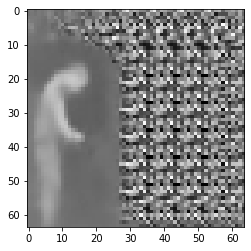

In [82]:
plt.imshow(mean_frames[50,:,:,0],cmap='gray')

### Anomaly score plot

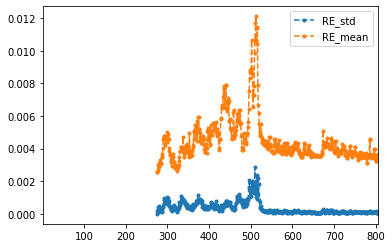

In [83]:

plt.plot(frame_numbers_cat,x_std_RE, label='RE_std',linestyle='--', marker='.')
plt.plot(frame_numbers_cat,x_mean_RE, label='RE_mean',linestyle='--', marker='.')
# plt.xticks([i+1 for i in range(max(frame_numbers))])
plt.xlim(1,max(frame_numbers_cat))
# plt.ylim(0,1)
plt.legend()
# plt.axvspan(start,end, alpha = 0.5)
plt.show()

## Create Animation

In [84]:
#dictionary tracked frames number to index
indices=list(range(len(frame_numbers_cat)))
track_indices=dict(zip(frame_numbers_cat,indices))

In [85]:
#convert gray to rgb, add boxes to track frames
actual_frames=video["ALL_FRAME"]
org_color_images=[]
recon_color_images=[]
for i in range(len(actual_frames)):
    if i+1 in track_indices:
        box=num_box_dict[i+1]
        left, top, right, bottom=int(box[1]*width),int(box[0]*height),int(box[3]*width),int(box[2]*height)
        #add box in org frame
        clr_img=cv2.rectangle(gray_color_image(actual_frames[i]), (left, top), (right, bottom), (0, 0, 255),1)
        org_color_images.append(clr_img)
        #recons image -> color img
        recon_im=gray_color_image(mean_frames[track_indices[i+1]])
        clr_img=cv2.rectangle(recon_im, (left, top), (right, bottom), (0, 0, 255),1)
        recon_color_images.append(clr_img)
    else:
        org_color_images.append(gray_color_image(actual_frames[i]))
        recon_color_images.append(np.zeros((height,width,3),dtype='uint8'))


In [86]:
print(len(org_color_images))
print(len(recon_color_images))

804
804


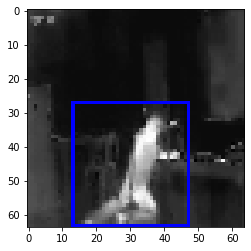

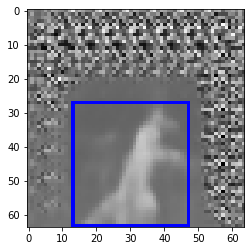

In [87]:
index=500
plt.imshow(org_color_images[index])
plt.show()
plt.imshow(recon_color_images[index])
plt.show()

In [88]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm

In [89]:
'''
This function is the extension of function animate_fall_detect_Spresen() from https://github.com/JJN123/Fall-Detection/blob/master/util.py

'''
def animate_fall_detect_animation(actual_frames, recons,recons_timestamp, scores,score_type='RE_mean',threshold = 0,to_save = './test.mp4'):
    '''
    Create animation from actual frames, reconstructed frames and frame level anomaly score with timestamps
    '''
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(2,2,height_ratios = [2,1])
    
    ht, wd = 64,64

    eps = .0001
    #setup figure
    #fig = plt.figure()
    fig, ((ax1,ax3)) = plt.subplots(1,2,figsize = (6,6))

    ax1.axis('off')
    ax3.axis('off')
    #ax1=fig.add_subplot(2,2,1)

    ax1=fig.add_subplot(gs[0,0])
    ax1.set_title("Original")
    ax1.set_xticks([])
    ax1.set_yticks([])


    #ax2=fig.add_subplot(gs[-1,0])
    ax2=fig.add_subplot(gs[1,:])

    #ax2.set_yticks([])
    #ax2.set_xticks([])
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Frame')
    ax2.set_xlim([1, len(actual_frames)])
    if threshold != 0:
        ax2.axhline(y= threshold, color='r', linestyle='dashed', label = 'RRE')
        ax2.legend()

    #ax3=fig.add_subplot(2,2,2)
    ax3=fig.add_subplot(gs[0,1])
    ax3.set_title("Reconstruction")
    ax3.set_xticks([])
    ax3.set_yticks([])

    #dictionary to frame number to indices
    indices=list(range(len(recons_timestamp)))
    track_indices=dict(zip(recons_timestamp,indices))
    #set up list of images for animation
    ims=[]
    track_ind=None
    for time in tqdm(range(len(actual_frames))):
        #plot images
        im1 = ax1.imshow(actual_frames[time])
        figure= recons[time]
        im2 = ax3.imshow(figure, cmap = 'gray', aspect = 'equal')
        
        if time+1 in track_indices:
            track_ind=track_indices[time+1]
            
        if track_ind is not None:
            scores_curr = scores[:track_ind+1]
            track_num=recons_timestamp[:track_ind+1]
            
            plot, = ax2.plot(track_num, scores_curr,'b.',linestyle='--', marker='.',label=score_type)
        else:
            plot, = ax2.plot([],'b.')
#             plot_r, = ax2.plot([],'b.')
            
            
    

        ims.append([im1, plot, im2]) #list of ims

    #run animation
    ani = animation.ArtistAnimation(fig,ims, interval= 30, repeat=False)
    
    ani.save(to_save)

    ani.event_source.stop()
    del ani
    plt.close()
#     plt.show()

In [90]:
demo_samples_path='demo_samples'
os.makedirs(demo_samples_path,exist_ok=True)

In [91]:
#user_input
score_type='mean'
video_name='Fall35'
save_path=demo_samples_path+'/'+video_name+'_'+score_type+'.mp4'

In [92]:
animate_fall_detect_animation(org_color_images,recon_color_images,frame_numbers_cat, scores=x_mean_RE,score_type='RE_'+score_type,to_save = save_path)


100%|██████████| 804/804 [00:02<00:00, 398.13it/s]
